In [232]:
from matplotlib import pyplot as plt
import matplotlib as mp
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import sklearn.manifold
from scipy import cluster
import seaborn as sns
import sklearn.datasets as sk_data
import sklearn.metrics as metrics
import requests
import json
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize
import re
%matplotlib inline

We begin by cleaning the academic dataset of irrelevant business. We only want too look at restaurants in Las Vegas, so we iterate through all of the json objects and filter out the unneeeded businesses, and add them to a list names.

In [233]:
restaurants = {}
names=[]
with open('yelp_academic_dataset_business.json') as data:
    for i in data:
        d = json.loads(i)
        if (d['city']=='Las Vegas'):
            if ('Restaurants' in d['categories']):
                restaurants[d['business_id']] = {'latitude':d['latitude'], 'longitude':d['longitude']}
                names.append(d['name'])
restaurants

{'2xo91erKN-n7bDJcHLrmwQ': {'latitude': 36.1652870178223,
  'longitude': -115.208770751953},
 'rKKKwK521j5TdtyG4JOi4Q': {'latitude': 36.0553391, 'longitude': -115.2259983},
 'HI7tHbCuLMV9MzXXDPamjA': {'latitude': 36.1569058833674,
  'longitude': -115.334510328396},
 'MdOWvWXCPR9mhvZ3AHZOQg': {'latitude': 36.126211, 'longitude': -115.209584},
 'kcx-OLbCU2CAwUHDLUnP-g': {'latitude': 36.1088082, 'longitude': -115.173583},
 'hSMDtxfFtfBmrHx7d-3Eeg': {'latitude': 36.1431918, 'longitude': -115.1750346},
 'JIuHb_asyUKq5n0MJDQCfQ': {'latitude': 36.0702141, 'longitude': -115.2620348},
 'lQwxl7ZFC24P9-fp2ewCSg': {'latitude': 36.120832, 'longitude': -115.171846},
 'Ba3-fDVhzLahunTUEMTsKg': {'latitude': 36.1143948, 'longitude': -115.27811},
 'MQqf0EPF7TOte49T2Op2Kw': {'latitude': 36.219859, 'longitude': -115.250331},
 'PSg-nm2d7WLP3Jw2k75KFA': {'latitude': 36.1944211, 'longitude': -115.2468132},
 '-nRgJjyPsNiPMhBTdTvwrA': {'latitude': 36.130978, 'longitude': -115.115914},
 'hoy0dMyKvspyMCFanDX2Yg'

In [234]:
bId = []
long = []
lat = []

for x, y in restaurants.items():
    bId.append(x)
    long.append((y.get('longitude')))
    lat.append((y.get('latitude')))
long = np.array(long)
lat = np.array(lat)

print(long)
print(lat)

[-115.20877075 -115.2259983  -115.33451033 ..., -115.1149077  -115.1763486
 -115.15706062]
[ 36.16528702  36.0553391   36.15690588 ...,  36.02818     36.1173156
  36.16369101]


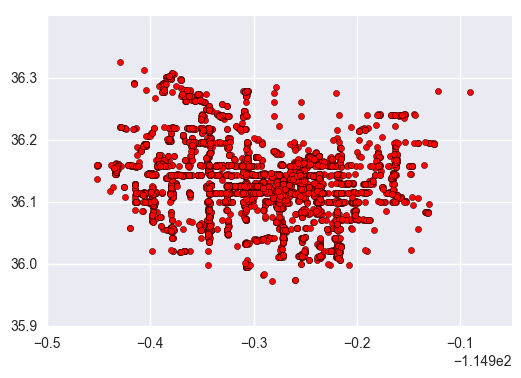

In [235]:
plt.scatter(long, lat, c='red', s=20)

In [236]:
# file = 'Restaurant_Inspections.json'
# data = []
# with open(file) as f:
#     for line in f:
#         data.append(json.loads(line))

We read in the Restaurant Inspections dataset into a pandas dataframe.

In [237]:
df = pd.read_csv('Restaurant_Inspections.csv',header=0)
# df = df[df.City == 'Las Vegas']
# df = (df[df['Inspection Result'] == 'Closed with Fees']).append(df[df['Inspection Result'] == 'Closed without Fees'])

df.shape

#with open ('Resaurant_Inspections.csv') as file:
#   for line in file:
#      if (line[6]=='Las Vegas' && line[]

/Users/takumihouse/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(123919, 23)

We begin cleaning the dataset by checking the cities in which these health inspections took place. Although this dataset is from the Las Vegas Open Data Portal, it contains data from restaurants all around Nevada, as far as 70 miles from the city.
I decide to do this in a step by step process, making sure to check how many lines are removed by every parameter.

In [238]:
df = df[df.City == 'Las Vegas']
df.shape

(94700, 23)

Next, we clean the dataset of health code inspections that do not pertain to restaurants. <br> We define restaurants to be: <br> Places of business open to the public who serve food in exchange for monetary payment. <br> Therefore, we remove the categories that do no adhere to these standards.

In [239]:
categories = df['Category Name'].unique().tolist()
print(categories)

['Pantry', 'Special Kitchen', 'Garde Manger', 'Kitchen Bakery', 'Bar / Tavern', 'Buffet', 'Snack Bar', 'Restaurant', 'Banquet Support', 'Portable Unit', 'Banquet Kitchen', 'Portable Bar', 'Meat/Poultry/Seafood', 'Vegetable Prep', 'Caterer', 'Barbeque', 'Confection', 'Concessions', 'Produce Market', 'Institutional Food Service', 'Elementary School Kitchen', 'Self-Service Food Truck', 'Bakery Sales', 'Food Trucks / Mobile Vendor', 'Grocery Store Sampling', 'Beer Bar', 'Childcare Kitchens', "Farmer's Market", 'Main Kitchen', 'Frozen Meat Sales']


In [240]:
categories.remove('Elementary School Kitchen')
categories.remove('Grocery Store Sampling')
categories.remove('Farmer\'s Market')
categories.remove('Caterer')
categories.remove('Concessions')
categories.remove('Institutional Food Service')
categories.remove('Banquet Support')

In [241]:
df = df[df['Category Name'].isin(categories)]
df.shape

(91735, 23)

In [242]:
coord_strings = df['Location 1'].tolist()

We convert our points from strings to the appropriate float tuple format, and plot our points to see what our spread of inspec looks like.

In [243]:
import ast
xcoords = []
ycoords = []
for coord in coord_strings:
    xcoords.append(ast.literal_eval(coord)[0])
    ycoords.append(ast.literal_eval(coord)[1])

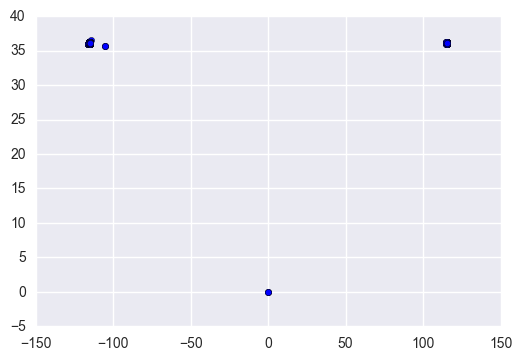

In [244]:
plt.scatter(ycoords, xcoords, c = 'b')

It is evident that there are some outlier coordinates. We aren't certain whether these are due to input errors, or because our cleaning was not sufficient.

Upon further inspection, we realize that some of the y coordinates have erroneously been negated, from ~-115 to ~115. We iterate through the dataset and fix the offending coordinates.

In [245]:
count = 0
for idx, ycoord in enumerate(ycoords):
    if ycoord > 0:
        ycoords[idx] = ycoord * -1
        count += 1
print('{} coordinates fixed.'.format(count))

574 coordinates fixed.


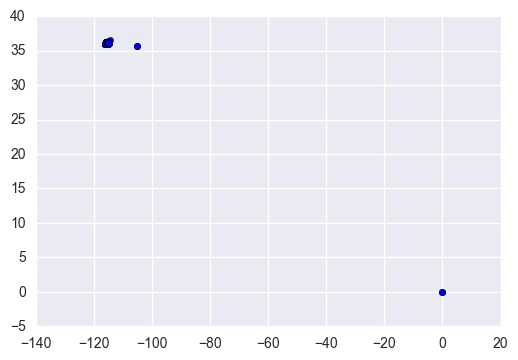

In [246]:
plt.scatter(ycoords, xcoords, c = 'b')

That's better, but it looks like there are a few points at (0,0), likely because coordinate information wasn't provided.

In [247]:
# df = df[df['Location 1'] != '(0, 0)']
df['Coordinates'] = list(zip(xcoords, ycoords))
df.head()

,Serial Number,Permit Number,Restaurant Name,Location Name,Category Name,Address,City,State,Zip,Current Demerits,...,Employee ID,Inspection Type,Inspection Demerits,Inspection Grade,Permit Status,Inspection Result,Violations,Record Updated,Location 1,Coordinates
11,DA0001715,PR0000426,CAESARS AUGUSTUS BUTLER PANTRY,CAESARS PALACE HOTEL & CASINO,Pantry,3570 S Las Vegas Blvd,Las Vegas,Nevada,89109-8924,3,...,EE7000417,Routine Inspection,0,A,NaN,Compliant,NaN,02/21/2013 10:26:12 PM,"(36.1161559, -115.1750576)","(36.1161559, -115.1750576)"
12,DA0001716,PR0000426,CAESARS AUGUSTUS BUTLER PANTRY,CAESARS PALACE HOTEL & CASINO,Pantry,3570 S Las Vegas Blvd,Las Vegas,Nevada,89109-8924,3,...,EE7000567,Routine Inspection,2,A,NaN,Compliant,NaN,02/21/2013 10:26:12 PM,"(36.1161559, -115.1750576)","(36.1161559, -115.1750576)"
13,DA0001728,PR0000427,CAESARS DIAMOND LOUNGE KITCHEN,CAESARS PALACE HOTEL & CASINO,Special Kitchen,3570 S Las Vegas Blvd,Las Vegas,Nevada,89109-8924,8,...,EE7000417,Routine Inspection,4,A,NaN,Compliant,14,02/21/2013 10:26:12 PM,"(36.1161559, -115.1750576)","(36.1161559, -115.1750576)"
14,DA0001773,PR0000434,CAESARS BAKERY WAREWASH,CAESARS PALACE HOTEL & CASINO,Special Kitchen,3570 S Las Vegas Blvd,Las Vegas,Nevada,89109-8924,3,...,EE7000417,Routine Inspection,7,A,NaN,Compliant,14232831,01/22/2014 02:03:44 PM,"(36.1161559, -115.1750576)","(36.1161559, -115.1750576)"
15,DA0001776,PR0000434,CAESARS BAKERY WAREWASH,CAESARS PALACE HOTEL & CASINO,Special Kitchen,3570 S Las Vegas Blvd,Las Vegas,Nevada,89109-8924,3,...,EE7000392,Routine Inspection,2,A,NaN,Compliant,NaN,01/22/2014 02:03:44 PM,"(36.1161559, -115.1750576)","(36.1161559, -115.1750576)"


In [248]:
df = df[df['Coordinates'] != (0,0)]
# df = df[df['Coordinates'][1] < -112]
df.shape

(91732, 24)

Creating Series in the df for ease of use when checking coordinate limits.

In [249]:
coordinates_list = df['Coordinates'].tolist()
xcoords = []
ycoords = []
for coordinates in coordinates_list:
    xcoords.append(coordinates[0])
    ycoords.append(coordinates[1])
df['X'] = xcoords
df['Y'] = ycoords
df.head()

,Serial Number,Permit Number,Restaurant Name,Location Name,Category Name,Address,City,State,Zip,Current Demerits,...,Inspection Demerits,Inspection Grade,Permit Status,Inspection Result,Violations,Record Updated,Location 1,Coordinates,X,Y
11,DA0001715,PR0000426,CAESARS AUGUSTUS BUTLER PANTRY,CAESARS PALACE HOTEL & CASINO,Pantry,3570 S Las Vegas Blvd,Las Vegas,Nevada,89109-8924,3,...,0,A,NaN,Compliant,NaN,02/21/2013 10:26:12 PM,"(36.1161559, -115.1750576)","(36.1161559, -115.1750576)",36.116156,-115.175058
12,DA0001716,PR0000426,CAESARS AUGUSTUS BUTLER PANTRY,CAESARS PALACE HOTEL & CASINO,Pantry,3570 S Las Vegas Blvd,Las Vegas,Nevada,89109-8924,3,...,2,A,NaN,Compliant,NaN,02/21/2013 10:26:12 PM,"(36.1161559, -115.1750576)","(36.1161559, -115.1750576)",36.116156,-115.175058
13,DA0001728,PR0000427,CAESARS DIAMOND LOUNGE KITCHEN,CAESARS PALACE HOTEL & CASINO,Special Kitchen,3570 S Las Vegas Blvd,Las Vegas,Nevada,89109-8924,8,...,4,A,NaN,Compliant,14,02/21/2013 10:26:12 PM,"(36.1161559, -115.1750576)","(36.1161559, -115.1750576)",36.116156,-115.175058
14,DA0001773,PR0000434,CAESARS BAKERY WAREWASH,CAESARS PALACE HOTEL & CASINO,Special Kitchen,3570 S Las Vegas Blvd,Las Vegas,Nevada,89109-8924,3,...,7,A,NaN,Compliant,14232831,01/22/2014 02:03:44 PM,"(36.1161559, -115.1750576)","(36.1161559, -115.1750576)",36.116156,-115.175058
15,DA0001776,PR0000434,CAESARS BAKERY WAREWASH,CAESARS PALACE HOTEL & CASINO,Special Kitchen,3570 S Las Vegas Blvd,Las Vegas,Nevada,89109-8924,3,...,2,A,NaN,Compliant,NaN,01/22/2014 02:03:44 PM,"(36.1161559, -115.1750576)","(36.1161559, -115.1750576)",36.116156,-115.175058


Based on maps and resources online, and the spread of our reviews, we set upper and lower limits, which is an area of approximately 100 km, more enough to include all of Las Vegas.

In [250]:
df = df[df['Y'] < -114.5]
df = df[df['Y'] > -115.6]
df.shape

(91701, 26)

In [251]:
df_clean = df.reset_index(drop = True)
df_clean.shape

(91701, 26)

In [252]:
coordinates_list = df_clean['Coordinates'].tolist()
xcoords = []
ycoords = []
for coordinates in coordinates_list:
    xcoords.append(coordinates[0])
    ycoords.append(coordinates[1])

The new plot of health inspection reports.

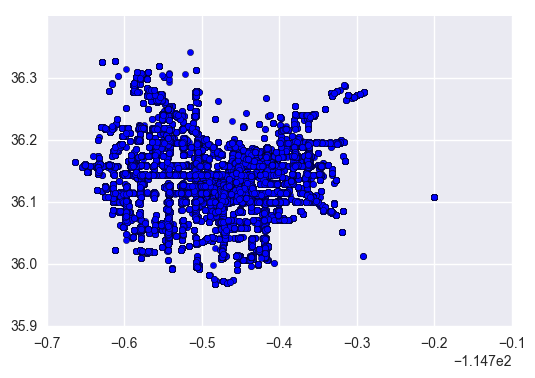

In [253]:
plt.scatter(ycoords, xcoords, c = 'b')

A plot of health inspection reports overlayed on th set of restaurants in the academic dataset. It looks like a fairly good spread.

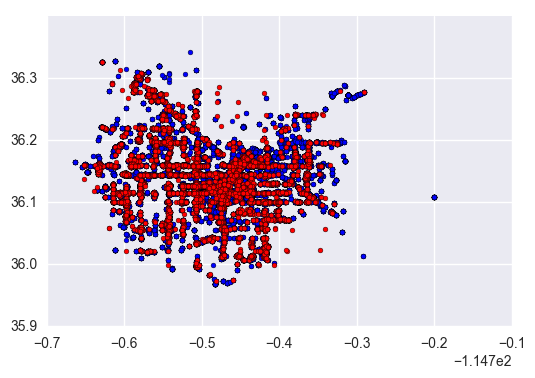

In [254]:
plt.scatter(ycoords, xcoords, c = 'b', s=12)
plt.scatter(long, lat, c='r', s=12)